# Stimulation example

This notebook will demonstrate how to construct stimuli using a variety of different predefined classes in `neurolib`.

You can then apply them as an input to a whole-brain model. As an example, we will see how to add an external current to the excitatory population of the `ALNModel`.

In [1]:
# change to the root directory of the project
import os

if os.getcwd().split("/")[-1] in ["examples", "dev"]:
    os.chdir("..")

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt

# Some useful functions are provided here
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim
import numpy as np
import scipy
# Let's import the aln model
from neurolib.models.aln import ALNModel

## Let's talk stimuli

`neurolib` offers a range of external stimuli you can apply to your models. These range from basic noise processes like a Wiener process or an Ornstein-Uhlenbeck process, to more simple forms of inputs such as sinousoids, rectified inputs etc. All stimuli are based on the `ModelInput` class, and are available in the `neurolib.utils.stimulus` subpackage. In the following we will detail the implemented inputs and also show how to easily implement your own custom stimulus further below.

All inputs are initialized as classes. Three different functions are provided for the generation of the actual stimulus as a usable input:
- `as_array(duration, dt)` - will return numpy array.
- `as_cubic_splines(duration, dt)` - will return a CubicHermiteSpline object, which represents a spline representation of the given input - useful for `jitcdde` backend in `MultiModel`.
- `to_model(model)` - the easiest one - infers the duration, dt and number of nodes from the simulated model itself and returns numpy array of an appropriate shape.

Each stimulus type has their own init function with attributes that apply to the specific kind of stimulus. However, all of them include the attributes `n` and `seed`. `n` controls how many spatial dimensions the stimulus should have, and in the case of stochastic inputs, such as a noisy Ornstein-Uhlenbeck process, this controls the number of independent realizations that are returned. For a determinitic stimulus, such as the sinusoidal input, this just returns a copy of itself.

### Zero input - for convenience
You'll probably never use it, but you know, it's there... Maybe you can use it as a "pause" when concatenating two different stimuli. 

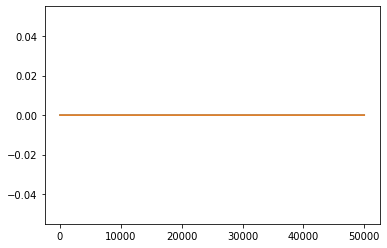

In [14]:
duration = 5000  # 5 seconds
dt = 0.1
inp = stim.ZeroInput(n=2).as_array(duration, dt)
plt.plot(inp.T);

### WienerProcess
Basic Wiener process $dW$, i.e. random numbers drawn from $N(0, \sqrt{dt})$

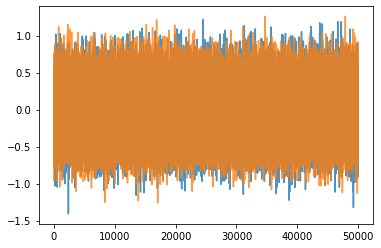

In [15]:
inp = stim.WienerProcess(n=2).as_array(duration, dt)
plt.plot(inp.T, alpha=0.8);

### Ornstein-Uhlenbeck process
Ornstein-Uhlenback process, i.e. $\dot{x} = (\mu - x)/\tau \cdot dt + \sigma\cdot dW$

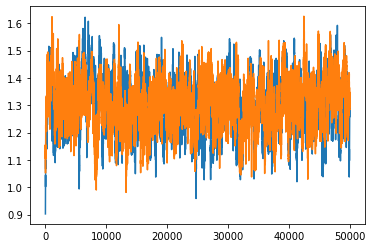

In [21]:
inp = stim.OrnsteinUhlenbeckProcess(mu=1.3, sigma=0.04, tau=10.0, n=2).as_array(duration, dt)
plt.plot(inp.T);

### Step input
Just a bias, or a DC offset, that you can use in combination with other types of stimuli.

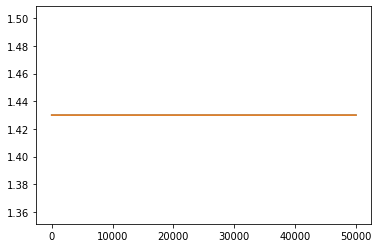

In [23]:
inp = stim.StepInput(step_size=1.43, n=2).as_array(duration, dt)
plt.plot(inp.T);

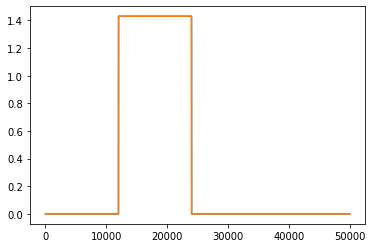

In [69]:
# you can also set stim_start and stim_end - in ms
inp = stim.StepInput(
    step_size=1.43, start=1200, end=2400, n=2
).as_array(duration, dt)
plt.plot(inp.T);

### Sinusoidal input

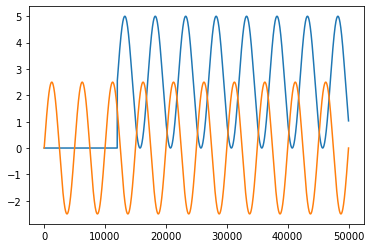

In [70]:
# frequency in Hz; dc_bias=True shifts input by its amplitude
inp = stim.SinusoidalInput(
    amplitude=2.5, frequency=2.0, start=1200, dc_bias=True
).as_array(duration, dt)
inp2 = stim.SinusoidalInput(amplitude=2.5, frequency=2.0).as_array(
    duration, dt
)
plt.plot(inp.T)
plt.plot(inp2.T);

### Square input

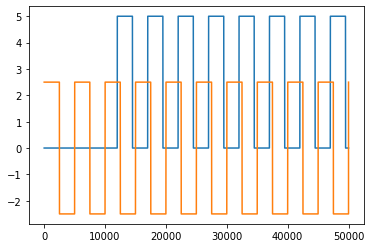

In [34]:
# frequency in Hz; dc_bias=True shifts input by its amplitude
inp = stim.SquareInput(
    amplitude=2.5, frequency=2.0, start=1200, dc_bias=True
).as_array(duration, dt)
inp2 = stim.SquareInput(amplitude=2.5, frequency=2.0).as_array(
    duration, dt
)
plt.plot(inp.T)
plt.plot(inp2.T);

### Linear ramp
When you need to go somwhhere slowly but surely

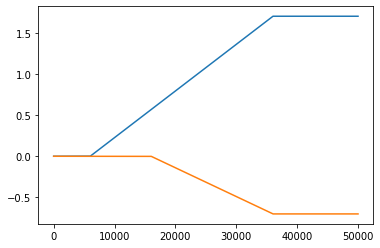

In [36]:
# ramp_length in ms
inp = stim.LinearRampInput(inp_max=1.7, ramp_length=3000, start=600).as_array(
    duration, dt
)
inp2 = stim.LinearRampInput(inp_max=-0.7, ramp_length=2000, start=1600).as_array(
    duration, dt
)
plt.plot(inp.T)
plt.plot(inp2.T);

### Exponential input
When you need to get there fast.

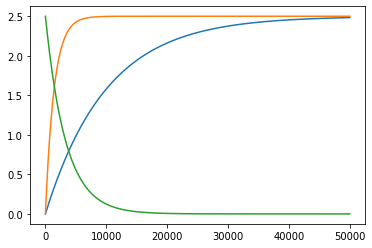

In [38]:
inp = stim.ExponentialInput(inp_max=2.5, exp_coef=5.0, exp_type="rise").as_array(
    duration, dt
)
inp2 = stim.ExponentialInput(inp_max=2.5, exp_coef=35.0, exp_type="rise").as_array(
    duration, dt
)
inp3 = stim.ExponentialInput(inp_max=2.5, exp_coef=15.0, exp_type="decay").as_array(
    duration, dt
)
plt.plot(inp.T)
plt.plot(inp2.T)
plt.plot(inp3.T);

### RectifiedInput
A mix of inputs that start with negative step, then we have exponential rise and subsequent decay to zero. Useful for detecting bistability

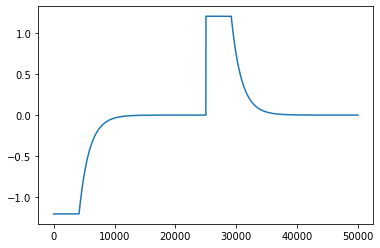

In [55]:
inp = stim.RectifiedInput(amplitude=1.2).as_array(duration, dt)
plt.plot(inp.T);

## Operations on stimuli
Sometimes you need to concatenate inputs in the temporal dimension to create a mix of different stimuli. This is easy with `neurolib`'s stimuli. All of them allow two operations: `+` for a sum of different stimuli and `&` to concatenate them (one after another). Below, we will show some of the weird combinations you can make.

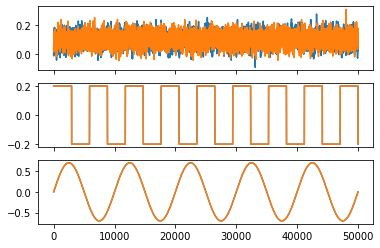

In [57]:
# let's create some basic inputs
ou = stim.OrnsteinUhlenbeckProcess(mu=0.1, sigma=0.04, tau=2.0, n=2)
sq = stim.SquareInput(amplitude=0.2, frequency=1.7, n=2)
sin = stim.SinusoidalInput(amplitude=0.7, frequency=1.0, n=2)

_, axs = plt.subplots(nrows=3, ncols=1, sharex=True)
for i, inp in enumerate([ou, sq, sin]):
    axs[i].plot(inp.as_array(duration, dt).T);

### Sum

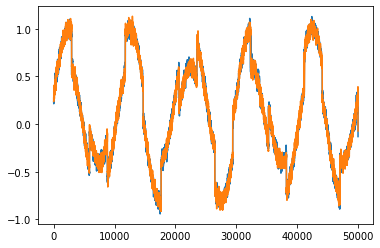

In [58]:
summed = ou + sq + sin
plt.plot(summed.as_array(duration, dt).T);

### Concatenation

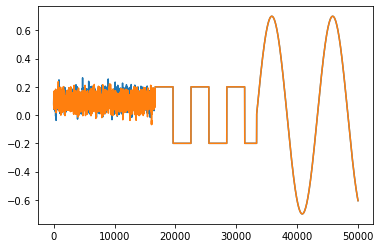

In [59]:
# same lengths - use &
conc = ou & sq & sin
plt.plot(conc.as_array(duration, dt).T);

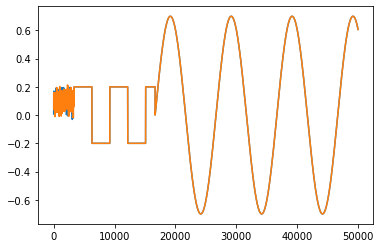

In [62]:
# can also do different length ratios, but for this you need to call ConcatenatedStimulus directly
conc = stim.ConcatenatedStimulus([ou, sq, sin], length_ratios=[0.5, 2, 5])
plt.plot(conc.as_array(duration, dt).T);

### Mixing the operations
You should be able to use as many `+` and `&` as you want. Go crazy.

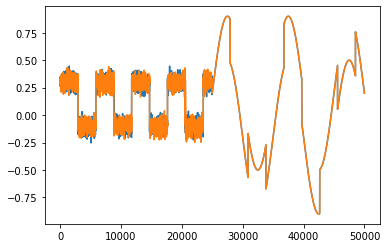

In [66]:
beast = (ou + sq) & (sq + sin)
plt.plot(beast.as_array(duration, dt).T);

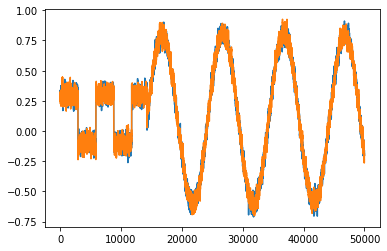

In [68]:
beast = stim.ConcatenatedStimulus([ou + sq, ou + sin], [2, 5])
plt.plot(beast.as_array(duration, dt).T);

## Creating a custom stimulus
Creating a custom stimulus is very easy and you can build your library of stimuili as inputs for your model. There are three necessary steps:
1. Subclass `stim.Input` for a basic input or `stim.Stimulus` to have the option to set `start` and `end` times.
2. Define an `__init__()` method with the necessary parameters of your stimulus and set the appropriate attributes.
3. Define a `generate_input(duration, dt)` method, which returns a numpy array as with a shape `(space, time)`
and that's it. Everything else described above is taken care of. Your new input class will be also support operations like `+` and `&`.

Below we implement a new stimulus class that represents currents caused by a Poission spike train convolved with an exponential kernel.

In [109]:
class PoissonNoiseWithExpKernel(stim.Stimulus):
    """
    Poisson noise with exponential kernel.
    By subclassing the `StimulusInput` we have an option to select `start` and `end`.
    """

    def __init__(
        self, amp, freq, tau_syn, start=None, end=None, n=1, seed=None
    ):
        # save parameters as attributes
        self.freq = freq
        self.amp = amp
        self.tau_syn = tau_syn
        # pass other params to parent class
        super().__init__(
            start=start, end=end, n=n, seed=seed
        )

    def generate_input(self, duration, dt):
        # this is a helper function that creates self.times vector
        self._get_times(duration=duration, dt=dt)
        # do the magic here: prepare output vector
        x = np.zeros((self.n, self.times.shape[0]))
        # compute total number of spikes
        total_spikes = int(self.freq * (self.times[-1] - self.times[0]) / 1000.0)
        # randomly put spikes into the output vector
        spike_indices = np.random.choice(
            x.shape[1], (self.n, total_spikes), replace=True
        )
        x[np.arange(x.shape[0])[:, None], spike_indices] = 1.0
        # create exponential kernel
        time_spike_end = -self.tau_syn * np.log(0.001)
        arg_spike_end = np.argmin(np.abs(self.times - time_spike_end))
        spike_kernel = np.exp(-self.times[:arg_spike_end] / self.tau_syn)
        # convolve over dimensions
        x = np.apply_along_axis(np.convolve, axis=1, arr=x, v=spike_kernel, mode="same")
        # self._trim_stim_input takes care of trimming the stimulus based on stim_start and stim_end
        return self._trim_stim(x * self.amp)

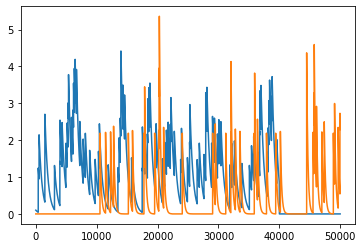

In [110]:
# test ride
inp = PoissonNoiseWithExpKernel(
    amp=1.2, freq=20.0, tau_syn=50.0, n=1, end=4000
).as_array(duration, dt)
inp2 = PoissonNoiseWithExpKernel(
    amp=2.2, freq=10.0, tau_syn=20.0, n=1, start=1000
).as_array(duration, dt)
plt.plot(inp.T)
plt.plot(inp2.T);

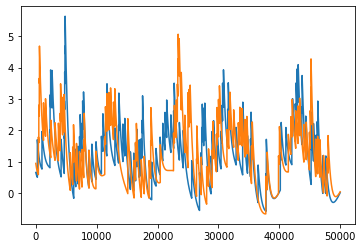

In [111]:
# sum and concat test
pois = PoissonNoiseWithExpKernel(freq=20.0, amp=1.2, tau_syn=50.0, n=2)

summed = pois + sin
plt.plot(summed.as_array(duration, dt).T);

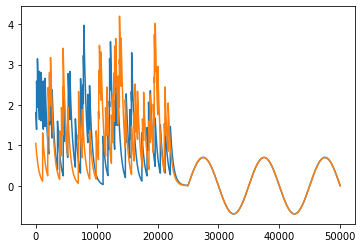

In [112]:
concat = pois & sin
plt.plot(concat.as_array(duration, dt).T);

## Using stimuli in `neurolib`
First, we initialize a single node.

In [113]:
model = ALNModel()
model.params["duration"] = 5 * 1000
model.params["sigma_ou"] = 0.2  # we add some noise

After creating a base for stimulus, we can simply call `to_model(model)` function and our stimulus is generated.

In [116]:
stimulus = stim.SinusoidalInput(amplitude=1.0, frequency=1.0).to_model(model)

The stimulus is then set as an input current parameter to the model. The parameter that models a current that goes to the excitatory population is called `ext_exc_current`. For the inhibitory population, we can use `ext_inh_current`. We can also set a firing rate input, that will then be integrated over the synapses using the parameter `model.params['ext_exc_rate']`.

In [117]:
model.params["ext_exc_current"] = stimulus
model.run()

When we plot the timeseries, we can see that the oscillatory activity locks to the stimulus.

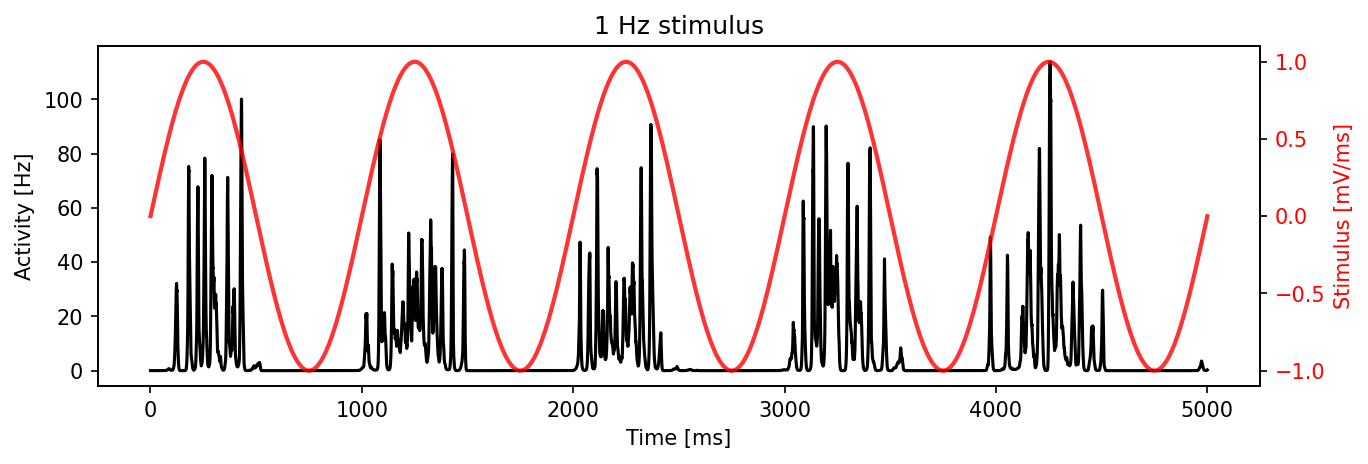

In [118]:
plt.figure(figsize=(10, 3), dpi=150)
plt.title("1 Hz stimulus")
ax1 = plt.gca()
ax1.plot(model.t, model.output.T, c="k")
ax2 = plt.gca().twinx()
ax2.plot(model.t, stimulus.squeeze(), lw=2, c="r", alpha=0.8)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Activity [Hz]")
ax2.set_ylabel("Stimulus [mV/ms]", color="r")
ax2.set_ylabel("Stimulus [mV/ms]", color="r")
ax2.tick_params(axis="y", labelcolor="r")

## Brain network stimulation

In [119]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [120]:
model = ALNModel(Cmat=ds.Cmat, Dmat=ds.Dmat)

# we chose a parameterization in which the brain network oscillates slowly
# between up- and down-states

model.params["mue_ext_mean"] = 2.56
model.params["mui_ext_mean"] = 3.52
model.params["b"] = 4.67
model.params["tauA"] = 1522.68
model.params["sigma_ou"] = 0.40

model.params["duration"] = 0.2 * 60 * 1000

In [121]:
def plot_output_and_spectrum(model, individual=False, vertical_mark=None):
    """A simple plotting function for the timeseries
    and the power spectrum of the activity.
    """
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 2), dpi=150, gridspec_kw={"width_ratios": [2, 1]}
    )
    axs[0].plot(model.t, model.output.T, lw=1)
    axs[0].set_xlabel("Time [ms]")
    axs[0].set_ylabel("Activity [Hz]")

    frs, powers = func.getMeanPowerSpectrum(model.output, dt=model.params.dt)
    axs[1].plot(frs, powers, c="k")

    if individual:
        for o in model.output:
            frs, powers = func.getPowerSpectrum(o, dt=model.params.dt)
            axs[1].plot(frs, powers)

    axs[1].set_xlabel("Frequency [Hz]")
    axs[1].set_ylabel("Power")

    plt.show()

### Without stimulation

In [122]:
model.run(chunkwise=True)

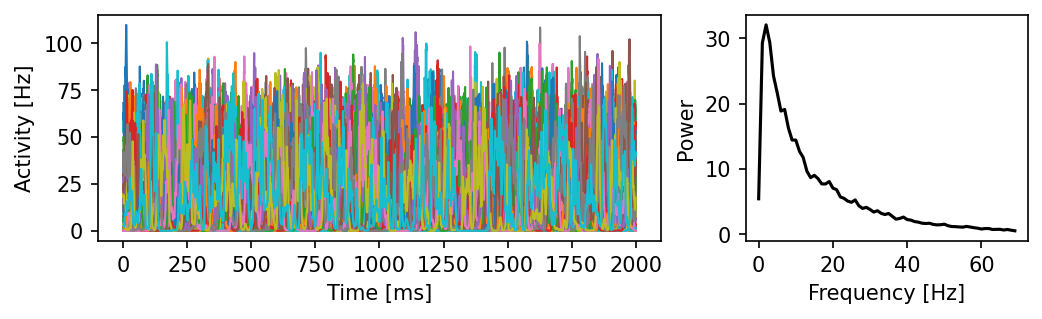

In [123]:
plot_output_and_spectrum(model)

### Constructing a stimulus

`neurolib` helps you to create a few basic stimuli out of the box using the function `stimulus.construct_stimulus()`.

In [124]:
# construct a stimulus
# we want 1-dim input - to all the nodes - 25Hz
ac_stimulus = stim.SinusoidalInput(amplitude=0.2, frequency=25.0).to_model(model)
print(ac_stimulus.shape)

# this stimulus is 1-dimensional. neurolib will threfore automatically apply it to *all nodes*.
model.params["ext_exc_current"] = ac_stimulus * 5.0

(80, 120000)


In [125]:
model.run(chunkwise=True)

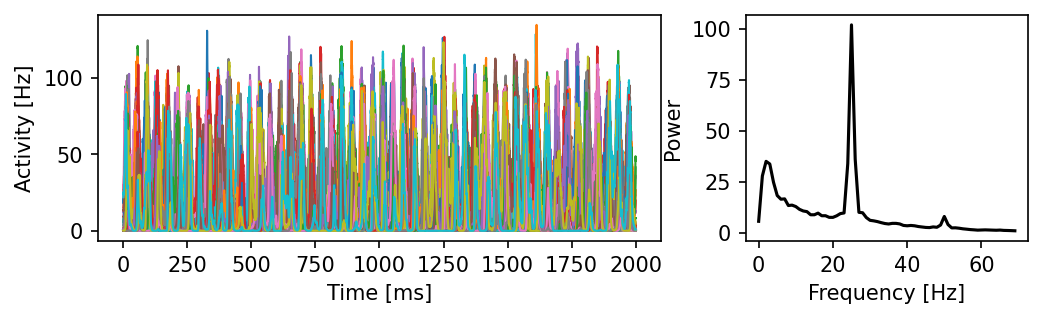

In [126]:
plot_output_and_spectrum(model)

### Focal stimulation

In the previous example, the stimulus was applied to *all nodes* simultaneously. We can also apply stimulation to a specific set of nodes.

In [127]:
# now we create multi-d input of 25Hz
ac_stimulus = stim.SinusoidalInput(amplitude=0.2, frequency=25.0).to_model(model)
print(ac_stimulus.shape)

# We set the input to a bunch of nodes to zero.
# This will have the effect that only nodes from 0 to 4 will be sitmulated!
ac_stimulus[5:, :] = 0

# multiply the stimulus amplitude
model.params["ext_exc_current"] = ac_stimulus * 5.0

(80, 120000)


In [128]:
model.run(chunkwise=True)

We can see that the spectrum has a peak at the frequency we stimulated with, but only in a subset of nodes (where we stimulated).

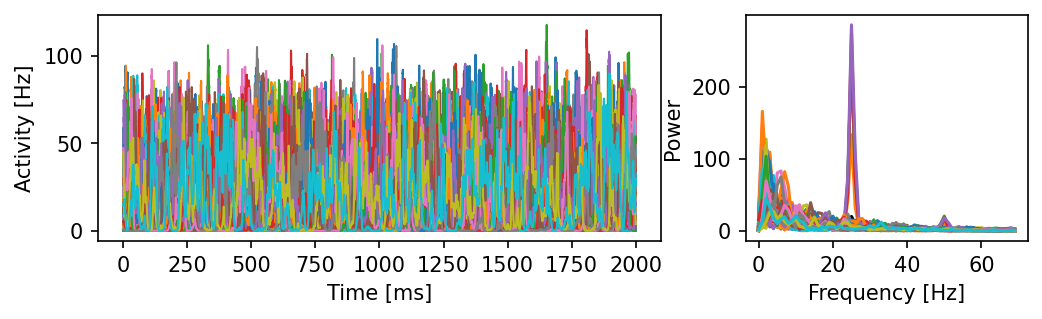

In [129]:
plot_output_and_spectrum(model, individual=True)